# Investigating the functions


In [29]:
import pandas as pd
import numpy as np
from sklearn.gaussian_process.kernels import Matern
import matplotlib.pyplot as plt
%matplotlib inline

f1_inp = np.load("./../function_8/initial_inputs.npy")
f1_out = np.load("./../function_8/initial_outputs.npy")
f1_out

q1_inp = [[0.585494, 0.602356, 0.195554, 0.053327, 0.289456, 0.422152,
       0.660623, 0.679865]

f1_inp, f1_out



(array([[0.60499445, 0.29221502, 0.90845275, 0.35550624, 0.20166872,
         0.57533801, 0.31031095, 0.73428138],
        [0.17800696, 0.56622265, 0.99486184, 0.21032501, 0.32015266,
         0.70790879, 0.63538449, 0.10713163],
        [0.00907698, 0.81162615, 0.52052036, 0.07568668, 0.26511183,
         0.09165169, 0.59241515, 0.36732026],
        [0.50602816, 0.65373012, 0.36341078, 0.17798105, 0.0937283 ,
         0.19742533, 0.7558269 , 0.29247234],
        [0.35990926, 0.24907568, 0.49599717, 0.70921498, 0.11498719,
         0.28920692, 0.55729515, 0.59388173],
        [0.77881834, 0.0034195 , 0.33798313, 0.51952778, 0.82090699,
         0.53724669, 0.5513471 , 0.66003209],
        [0.90864932, 0.0622497 , 0.23825955, 0.76660355, 0.13233596,
         0.99024381, 0.68806782, 0.74249594],
        [0.58637144, 0.88073573, 0.74502075, 0.54603485, 0.00964888,
         0.74899176, 0.23090707, 0.09791562],
        [0.76113733, 0.85467239, 0.38212433, 0.33735198, 0.68970832,
         0.

In [65]:
# toptop

# Exploratory Data Analysis (EDA) for Bayesian Optimization 

## **Objective**
The goal of the Exploratory Data Analysis (EDA) is to investigate the characteristics of the input-output relationships, data quality, and patterns that influence the performance of Bayesian Optimization. This analysis will help guide the selection of kernel parameters, acquisition functions, and input transformations to optimize model performance and robustness.
- Prior Knowledge: One of the features might not impact the outcome, consider to remove it


1. **Data Quality**  
   - Identify outliers via z-scores or IQR (ensures kernel parameters aren’t distorted by extreme values, example an outlier can create unrealistic length scales or amplitude of kernel parameters). Consider removing or transforming them.
   - Check for missing/null values and decide on imputation or removal (helps avoid skewing the GP’s fit). Remove duplicates if there is any  (prevents overemphasis on certain points).  


2. **Data Distribution**  
   - Plot histograms to spot skewness (so we can apply tansfromation of input and output), to address heteroscedascity.  
   - Analyse need to standarise features (kernels like RBF, Matern rely on distance metrics,If features have different scales (e.g., 0–1 vs. 1–10,000), larger ranges dominate distance calculations, distorting kernel behavior).
    - Check, variance, skewnes which can be needed in further steps

3. **Input-Output Relationships**  
   - Use correlation matrices to find strong or weak drivers of the target (remove features that are not relevant and add noise to the data).  
   - Visualize scatter/surface plots (reveals potential nonlinearity or interactions for better GP modeling).
   

6. **Noise and Uncertainty**  
    - Analyze residuals from a baseline model to gauge data noise (ensures an appropriate noise term in the GP).  
    - Estimate signal-to-noise ratio (prevents overfitting and reflects realistic uncertainty).
    - Consider removing  as the step above if it removes the noise 
     - If skewness is low but variance is high in RESIDUALS, focus on adding a noise term to the kernel, reults from step 2
7. **Feature Engineering**  
   - Apply dimensionality reduction (e.g., PCA) if many correlated features (simplifies model, reduces noise).  
   - Assess feature importance (e.g., SHAP) to prioritize critical inputs (focuses GP where it matters).
   

4. **Kernel Suitability Exploration,  Bounds and Feature Ranges**  
   - Amplitdue, check variance on ouput
   - Lengthscle check variance on input
   - Determine min-max bounds for each feature (the kernel in GP defines the relationship between features and their similarity, typically extends a bit further to avoid extraplotation, but not too far to avoid underfiting).  
   - Select length-scale according to how fast data changes (short for abrupt variation, longer for smoother patterns). 
   - Match kernel amplitude to output variance (captures overall scale of the data).  
   - Check Residual variance/ noise, when its high nise, wider bounds, low noise tigheter bounds 

8. **Acquisition Function Behavior**  
   - Monitor exploration-exploitation trade-offs (e.g., EI, PI, UCB) to ensure effective sampling (speeds convergence).  
   - Adjust parameters like \(\beta\) or \(\xi\) to fine-tune that balance (enhances optimization efficiency).


9. **Iterative Refinement**  
   - Revisit EDA after initial Bayesian runs (refine kernel hyperparameters, acquisition settings).  
   - Visualize updated surfaces and residuals (validates improvements and ensures robust GP performance).


In [2]:
from scipy.stats import skew 

pd_inp = pd.DataFrame(f1_inp)
pd_out = pd.DataFrame(f1_out, columns=["Output"])


pd_inp.describe()
pd_out.describe()

pd_inp.isnull().sum()  # No null on input 0 , 1 are the columns 
pd_out.isnull().sum()  # No null on output
sum(pd_inp.duplicated())   # 0 duplicates
sum(pd_out.duplicated())   # 0 duplicates

0

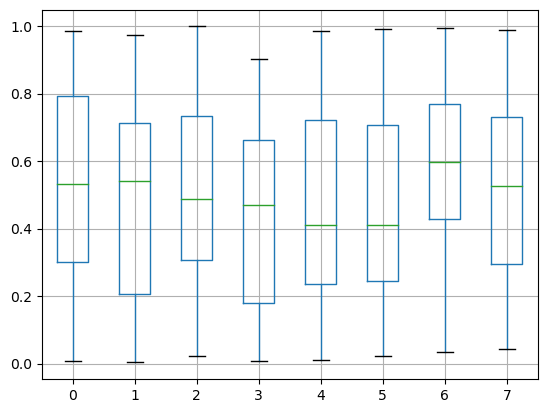

In [3]:
## Checking for outliers

pd_inp.boxplot() # OUTLIER DEDECTED ON THE 3RD FEATURE OF INPUTS
plt.show()

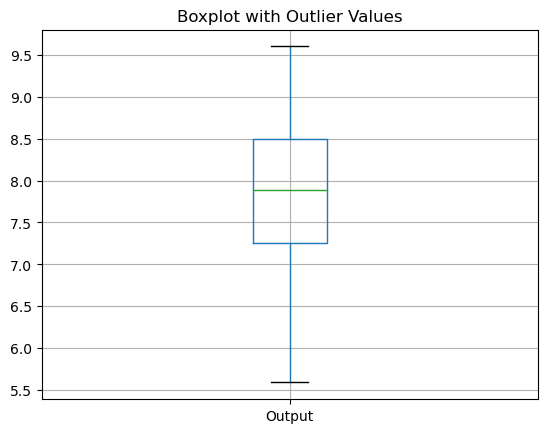

In [4]:
import matplotlib.pyplot as plt

# Create the boxplot
ax = pd_out.boxplot()

# Identify outliers using the 1.5*IQR rule
iqr = pd_out.quantile(0.75) - pd_out.quantile(0.25)
lower_bound = pd_out.quantile(0.25) - 1.5 * iqr
upper_bound = pd_out.quantile(0.75) + 1.5 * iqr

# Detect outliers
if isinstance(pd_out, pd.Series):
    outliers = pd_out[(pd_out < lower_bound) | (pd_out > upper_bound)]
elif isinstance(pd_out, pd.DataFrame):
    # Select the first column for comparison if it's a DataFrame
    column_name = pd_out.columns[0]
    outliers = pd_out.loc[(pd_out[column_name] < lower_bound[column_name]) |
                          (pd_out[column_name] > upper_bound[column_name]), column_name]

# Annotate each outlier
if isinstance(outliers, pd.Series):
    for outlier_idx, outlier_value in outliers.items():
        ax.annotate(f"{outlier_value:.2f}", xy=(1, outlier_value), xytext=(1.05, outlier_value),
                    arrowprops=dict(facecolor='black', arrowstyle="->"), fontsize=10)

# Show the plot
plt.title("Boxplot with Outlier Values")
plt.show()


## Distribution 

In [6]:
# # Find the outlier (minimum value, assuming outlier is the smallest value)
# outlier_idx = np.argmin(f1_out)
# outlier = f1_out[outlier_idx]

# # Exclude the outlier and find the second closest value to the outlier
# remaining_points = np.delete(f1_out, outlier_idx)  # Remove the outlier
# second_furthest_point = remaining_points[np.argmin(np.abs(remaining_points - outlier))]

# # Calculate the distance between the outlier and the second closest point
# distance = outlier - second_furthest_point

# # Update the outlier value
# new_point = second_furthest_point + distance / 2.2  # Halve the distance
# f1_out[outlier_idx] = new_point  # Update the array

# # Output relevant values
# outlier, second_furthest_point, distance, new_point, f1_out


(array([[<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>,
         <Axes: title={'center': '2'}>],
        [<Axes: title={'center': '3'}>, <Axes: title={'center': '4'}>,
         <Axes: title={'center': '5'}>],
        [<Axes: title={'center': '6'}>, <Axes: title={'center': '7'}>,
         <Axes: >]], dtype=object),
 array([[<Axes: title={'center': 'Output'}>]], dtype=object))

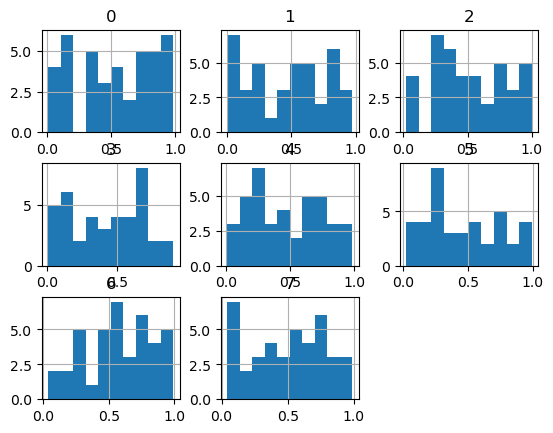

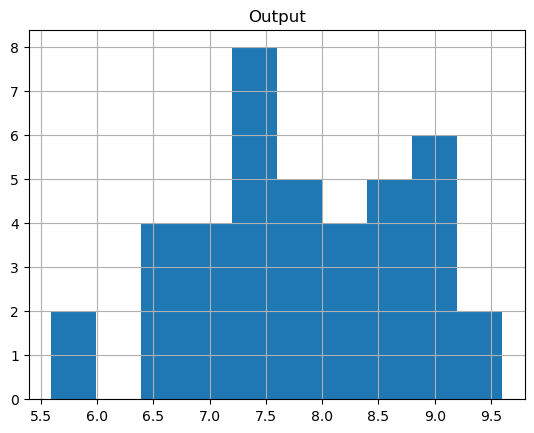

In [5]:
pd_inp.hist(), pd_out.hist()

In [7]:
skew(f1_inp),skew(f1_out)


np.var(f1_inp),np.var(f1_out)

(0.08612536030111803, 0.20160063217740953)

In [6]:
# Distribution affected by outlier 

# Input/Output Relationship Analysis 

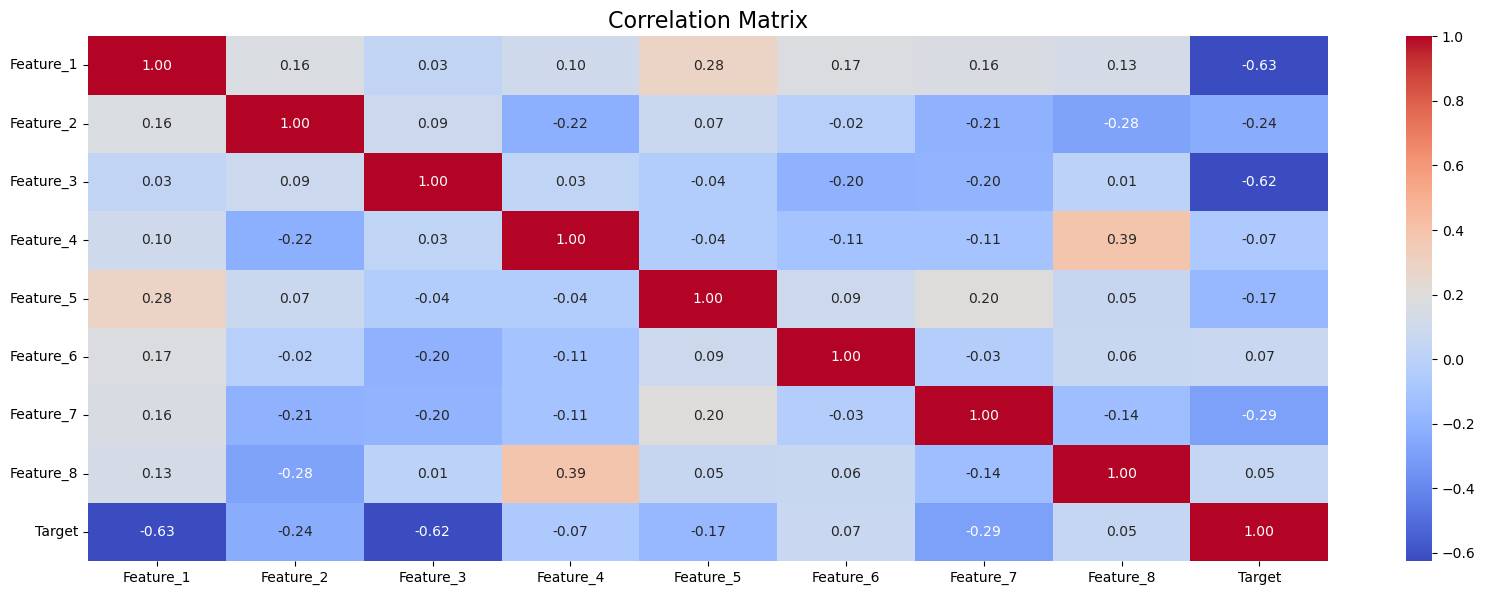

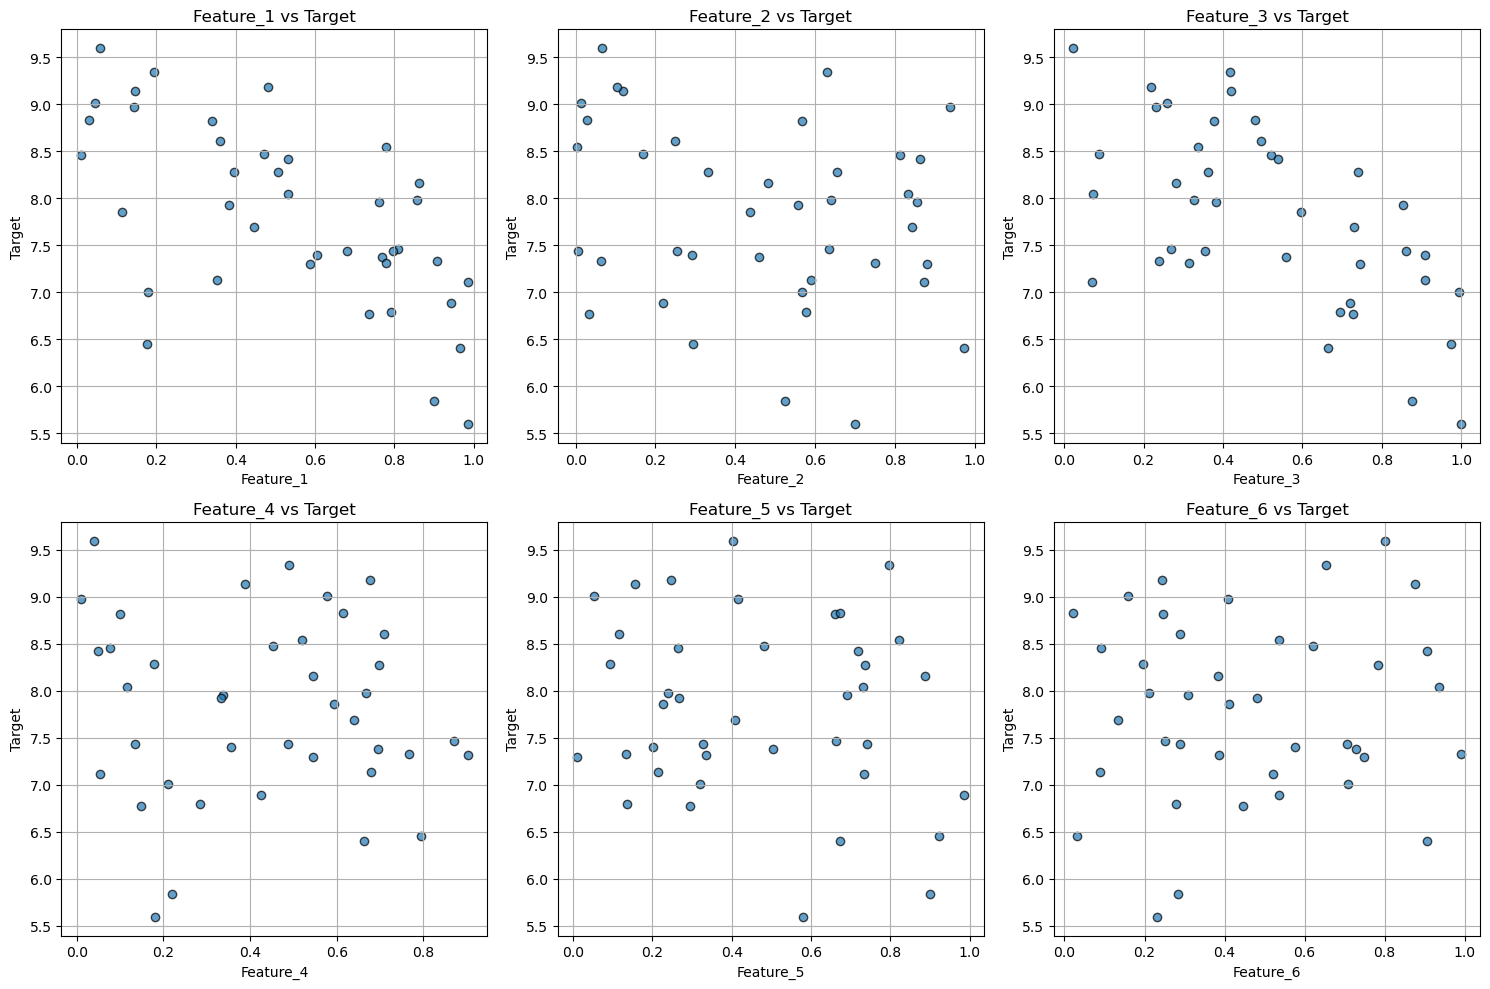

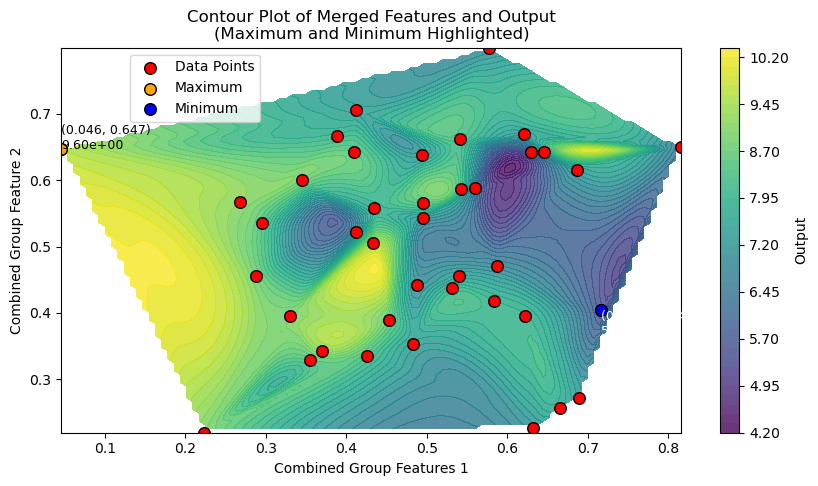

Max: 9.60e+00 at (0.0460, 0.6466)
Min: 5.59e+00 at (0.7159, 0.4039)


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D  # For 3D plotting

# Ensure f1_out is 1D
f1_out = f1_out.ravel()
num_features = f1_inp.shape[1]

#############################
# Layout with GridSpec for Correlation Matrix and Scatter Plots
#############################
import matplotlib.gridspec as gridspec

# Create a figure with GridSpec: top for correlation matrix, bottom for scatter plots
fig = plt.figure(figsize=(20, 15))
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1])  # Two rows: correlation matrix and scatter plots

# --- Top: Correlation Matrix ---
ax_corr = fig.add_subplot(gs[0])
data = np.hstack((f1_inp, f1_out.reshape(-1, 1)))
correlation_matrix = np.corrcoef(data.T)

sns.heatmap(
    correlation_matrix, 
    annot=True, 
    cmap="coolwarm", 
    fmt=".2f",
    xticklabels=[f"Feature_{i+1}" for i in range(num_features)] + ["Target"],
    yticklabels=[f"Feature_{i+1}" for i in range(num_features)] + ["Target"],
    ax=ax_corr
)
ax_corr.set_title("Correlation Matrix", fontsize=16)

# --- Bottom: Scatter Plots ---
fig_scatter, axes_scatter = plt.subplots(2, 3, figsize=(15, 10))  # 2 rows, 3 columns

for i in range(6):  # Loop through the 6 features
    row, col = divmod(i, 3)  # Determine the row and column for the current feature
    axes_scatter[row, col].scatter(f1_inp[:, i], f1_out, alpha=0.7, edgecolor="k")
    axes_scatter[row, col].set_xlabel(f"Feature_{i+1}")
    axes_scatter[row, col].set_ylabel("Target")
    axes_scatter[row, col].set_title(f"Feature_{i+1} vs Target")
    axes_scatter[row, col].grid(True)

# Hide unused subplots if necessary (for more flexible layouts)
for j in range(len(axes_scatter.flat)):
    if j >= 8:
        fig_scatter.delaxes(axes_scatter.flat[j])

plt.tight_layout()
plt.show()

#############################
# 3D Surface Plots for Two Feature Pairs
#############################

import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from scipy.stats import skew

# Example input data (replace with actual f1_inp and f1_out)
# f1_inp: shape (n_samples, n_features)
# f1_out: shape (n_samples,)
# Ensure f1_out is 1D
f1_out = f1_out.ravel()

def merge_features(data):
    """
    Merge features into two groups by averaging.
    Splits the columns into two halves and computes the mean of each half for each sample.
    """
    n_samples, n_features = data.shape
    # Determine splitting index (round up if odd number of features)
    split_idx = (n_features + 1) // 2  
    # First group: average of first half, second group: average of remaining
    group1 = np.mean(data[:, :split_idx], axis=1)
    group2 = np.mean(data[:, split_idx:], axis=1) if split_idx < n_features else np.zeros(n_samples)
    return group1, group2

# Merge features into two combined dimensions
x, y = merge_features(f1_inp)
z = f1_out

# Create grid points for interpolation over the range of merged features
grid_x, grid_y = np.mgrid[
    x.min():x.max():100j, 
    y.min():y.max():100j
]

# Interpolate the Z values for the grid using cubic method
grid_z = griddata((x, y), z, (grid_x, grid_y), method='cubic')

# Identify max/min points on original data in merged space
max_idx, min_idx = np.argmax(z), np.argmin(z)
max_x, max_y, max_z = x[max_idx], y[max_idx], z[max_idx]
min_x, min_y, min_z = x[min_idx], y[min_idx], z[min_idx]

# Plotting the contour plot
plt.figure(figsize=(10, 5))
contour = plt.contourf(grid_x, grid_y, grid_z, levels=50, cmap='viridis', alpha=0.8)
plt.colorbar(label="Output")
plt.scatter(x, y, color='red', edgecolor='black', s=70, label="Data Points")
plt.scatter([max_x], [max_y], color='orange', edgecolor='black', s=70, label="Maximum")
plt.text(max_x, max_y, f"({max_x:.3f}, {max_y:.3f})\n{max_z:.2e}", fontsize=9, color='black')
plt.scatter([min_x], [min_y], color='blue', edgecolor='black', s=70, label="Minimum")
plt.text(min_x, min_y, f"({min_x:.3f}, {min_y:.3f})\n{min_z:.2e}", fontsize=9, color='white',
         ha='left', va='top')
plt.xlabel("Combined Group Features 1")
plt.ylabel("Combined Group Feature 2")
plt.title("Contour Plot of Merged Features and Output\n(Maximum and Minimum Highlighted)")
plt.legend(loc="upper left", bbox_to_anchor=(0.1, 1.0))
plt.show()

print(f"Max: {max_z:.2e} at ({max_x:.4f}, {max_y:.4f})")
print(f"Min: {min_z:.2e} at ({min_x:.4f}, {min_y:.4f})")


# def plot_3d_surface(feature_idx1, feature_idx2, title):
#     # Extract two features and target
#     x = f1_inp[:, feature_idx1]
#     y = f1_inp[:, feature_idx2]
#     z = f1_out

#     # Create grid points for interpolation
#     grid_x, grid_y = np.meshgrid(
#         np.linspace(x.min(), x.max(), 100),
#         np.linspace(y.min(), y.max(), 100)
#     )

#     # Interpolate the Z values for the grid
#     grid_z = griddata((x, y), z, (grid_x, grid_y), method='cubic')

#     # Plotting the surface
#     fig = plt.figure(figsize=(10, 6))
#     ax = fig.add_subplot(111, projection="3d")
#      # Surface plot
#     surf = ax.plot_surface(grid_x, grid_y, grid_z, cmap="viridis", edgecolor="none", alpha=1)

#     # Adding red dots (ensure they are plotted after the surface)
#     ax.scatter(x_dots, y_dots, z_dots, color='red', s=50, label='Red Dots')

#     # Add color bar
#     cb = fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
#     cb.set_label("Target")

#     # Label axes and title
#     ax.set_xlabel(f"Feature {feature_idx1+1}")
#     ax.set_ylabel(f"Feature {feature_idx2+1}")
#     ax.set_zlabel("Target")
#     plt.title(title)
#     plt.legend(loc="best")
#     plt.show()




### Conclusion about input/ouput relationship
- Feature 4 has got strongest corerlation
- After merging features we now know the area expected for imporvmnet

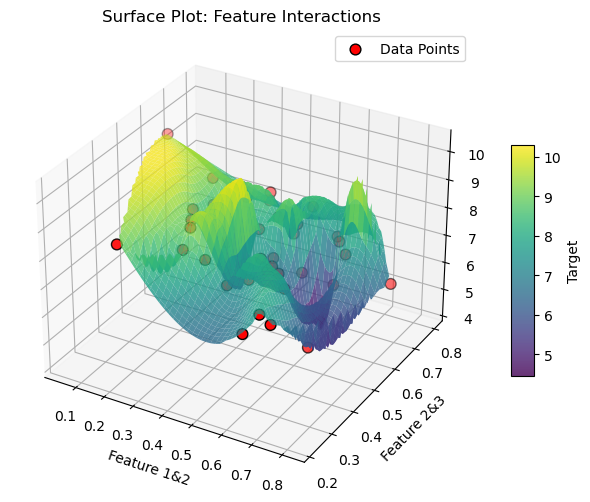

In [6]:
# x, y = DECLARED ABOVE
# z = f1_out

# Create grid points for interpolation
grid_x, grid_y = np.meshgrid(
    np.linspace(x.min(), x.max(), 100),
    np.linspace(y.min(), y.max(), 100)
)

# Interpolate the Z values for the grid
grid_z = griddata(
    (x, y), z, 
    (grid_x, grid_y), 
    method="cubic"
)

  # This visual can be good for function 1 to identify the two local minimas   
#     # Handle potential issues with NaN values in grid_z
#     if np.isnan(grid_z).any():
#         grid_z = np.nan_to_num(grid_z)  # Replace NaNs with zeros or interpolated values

# Plotting the surface
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection="3d")
surf = ax.plot_surface(
    grid_x, grid_y, grid_z, 
    cmap="viridis", 
    edgecolor="none", 
    alpha=0.8
)
# Scatter points (data points)
ax.scatter(x, y, z, color='red', edgecolor='black', s=60, label="Data Points")
ax.legend(loc="best")  # Add legend for clarity

cb = fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
cb.set_label("Target")
ax.set_xlabel("Feature 1&2")
ax.set_ylabel("Feature 2&3")
#     ax.set_zlabel("Target")
plt.title("Surface Plot: Feature Interactions")
plt.show()
# else:
#     print("Surface plot requires exactly 2 features in the input data.")
    
    
# The red on the 3d surface plot its just to make the plot easier to see


# Analysing Noise and Uncertianty

Noise and Uncertainty
     
    - If skewness is low but variance is high, focus on adding a noise term to the kernel, reults from step 2 
    - Analyze residuals from a baseline model to gauge data noise (ensures an appropriate noise term in the GP).
    - Estimate signal-to-noise ratio (prevents overfitting and reflects realistic uncertainty).
    - If skewness is low but variance is high, focus on adding a noise term to the kernel, reults from step 2
- Test after you have built the surrogate model, if there are future that just add noise and affect predictions 

In [ ]:
# Analysing skewnes and variance 




# Bench mark model for analysis( Linear Regression)

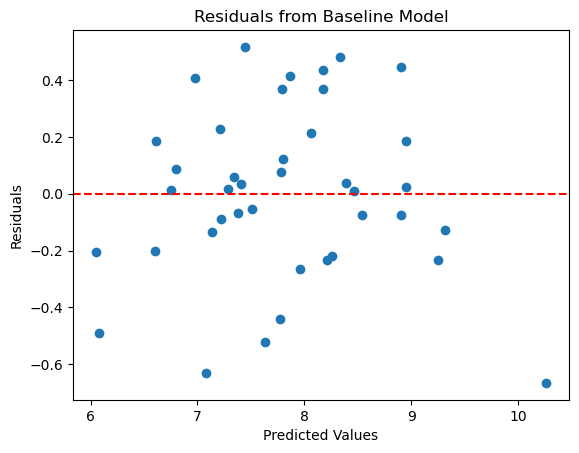

Residual Variance: 0.093
Residual Mean: -0.000


In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Example Data (replace with your data)
x = f1_inp
z = f1_out  # Observed target

# Fit a baseline model (Linear Regression)
model = LinearRegression()
model.fit(x, z)
z_pred = model.predict(x)  # Predictions from the baseline model

# Residuals
residuals = z - z_pred

# Plot Residuals
plt.scatter(z_pred, residuals)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals from Baseline Model")
plt.show()

# Print Residual Statistics
print(f"Residual Variance: {np.var(residuals, ddof=1):.3f}")
print(f"Residual Mean: {np.mean(residuals):.3f}")


In [10]:
# Signal Variance (Variance of Predictions)
signal_variance = np.var(z_pred, ddof=1)

# Residual Variance (Variance of Noise)
residual_variance = np.var(residuals, ddof=1)
residual_skewness = skew(residuals)
# Signal-to-Noise Ratio (SNR)
snr = signal_variance / residual_variance

# Display Metrics
print(f"Signal Variance: {signal_variance:.3f}")
print(f"Residual Variance (Noise): {residual_variance:.3f}")
print(f"Residual Skewnes : {residual_skewness:.3f}")
print(f"Signal-to-Noise Ratio (SNR): {snr:.3f}")


Signal Variance: 0.827
Residual Variance (Noise): 0.093
Residual Skewnes : -0.251
Signal-to-Noise Ratio (SNR): 8.905


- A high  signal variance means that the model is understanding well patterns of data
- A low residual variance is desirable, as it indicates that predictions are close to the observed values. If the surrogate model reduces residual variance, it is an improvement over the benchmark.
- Residual Skewness: Shows the symmetry of prediction errors (residuals). For benchmarking: A skewness near zero indicates balanced prediction errors, aligning with the assumption of normally distributed residuals.
- Signal-to-Noise Ratio (SNR): The ratio of signal variance to noise variance, measuring how dominant the signal is over noise. For benchmarking: A higher SNR means the model is better at distinguishing the signal from noise.

# Conclusion:
- There is a high v Residual Variance (Noise): 21446.895

# Kernel Parameters Analysis

4. **Kernel Suitability Exploration,  Bounds and Feature Ranges**  
   - Amplitdue, check variance on ouput will match kernel amplitude to output variance (captures overall scale of the data). 
   - Lengthscle check variance on input, will select length-scale according to how fast data changes (short for abrupt variation, longer for smoother patterns). 
   - Determine min-max bounds for each feature (the kernel in GP defines the relationship between features and their similarity, typically extends a bit further to avoid extraplotation, but not too far to avoid underfiting).  
  
   - Check Residual variance/ noise, when its high nise, wider bounds, low noise tigheter bounds 


In [11]:
output_variance = np.var(f1_out, ddof=1)
amplitude_init = np.sqrt(output_variance)
input_variance = np.var(f1_inp, axis=0, ddof=1)
length_scale_init = np.sqrt(input_variance)
min_bounds = np.min(f1_inp, axis=0)
max_bounds = np.max(f1_inp, axis=0)

# Extend bounds slightly (10% of range)
range_extension = 0.1 * (max_bounds - min_bounds)
extended_min_bounds = min_bounds - range_extension
extended_max_bounds = max_bounds + range_extension


amplitude_init, length_scale_init, [extended_min_bounds, extended_max_bounds]

(0.9589664138411572,
 array([0.31067591, 0.30970561, 0.28244004, 0.26147911, 0.28138046,
        0.27737568, 0.25791305, 0.28134747]),
 [array([-0.08860986, -0.09363653, -0.074667  , -0.08035074, -0.08807643,
         -0.07469963, -0.05979169, -0.05272383]),
  array([1.08363223, 1.07103582, 1.09648118, 0.99238   , 1.08462731,
         1.08705686, 1.08861506, 1.08343501])])

- Start with the above Amplitude but let the optimizer refine it during training

- Start with the above Lenfthscale but let the optimizer refine it during training

- Check Residual variance/ noise, when its high nise, wider bounds, low noise tigheter bounds

<span style="color: green;">
Strategy taken during this project is that I avoid input/output transformation to start with, and get the Log Marginal Likelihood. Then perform transformation and check the difference.
</span>


# ***************************** Output Transformation ******************************* 
- I will use Yeo-Johnson method to hanlde the heteroscedastic nature of the data, tranform outputs, and fic asymmetric skewness. 
- Reason I am using Yeo-Johnson is because we have positive and negative values as ouput 



In [10]:
from sklearn.preprocessing import PowerTransformer
import numpy as np

# Ensure f1_out contains only positive values
if np.any(f1_out <= 0):
    raise ValueError("Box-Cox transformation requires all values to be positive. Please shift the data.")

# Apply Box-Cox transformation
f1_out_transformed = PowerTransformer(method='box-cox').fit_transform(f1_out.reshape(-1, 1))

#


# ************************** Input Transformation************************** 
- #### First I will use the Kumaraswammy Cumulative Distribution Function to addres:

- Non Stationary nature of the function, the way way the patter in the data changes over the unput space, example, rapidly grows in some regions and slower in some other regions 
- I will use the CDF and finds its best parameters by minimising NLML(Negative Log Marginal Likelyhood)

In [11]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, ConstantKernel as C, WhiteKernel
from scipy.optimize import minimize

from sklearn.preprocessing import MinMaxScaler

# Normalize the input
scaler = MinMaxScaler()
f1_inp_normalized = scaler.fit_transform(f1_inp)
np.std(f1_inp_normalized), np.std(f1_inp)
skew(f1_inp_normalized), skew(f1_inp)
# f1_inp_normalized

(array([-0.20119899, -0.09707247,  0.11824686, -0.06270523,  0.14362313,
         0.29202253, -0.34418326, -0.03910658]),
 array([-0.20119899, -0.09707247,  0.11824686, -0.06270523,  0.14362313,
         0.29202253, -0.34418326, -0.03910658]))

In [16]:
# Not happy with the above result, I will try another strategy to get the best parametrs for the KUMARASUAMMY 

#!pip install deap


In [13]:
import numpy as np
from scipy.stats import skew
from deap import base, creator, tools, algorithms
import random
from tqdm import tqdm

# Define the warp function as before
def kumaraswamy_warp(X, a, b):
    X_clipped = np.clip(X, 1e-6, 1 - 1e-6)
    return 1 - (1 - X_clipped ** a) ** b

# Objective function
def evaluate(individual):
    a, b = individual
    X_warped = kumaraswamy_warp(f1_inp_normalized, a, b)
    variance = np.var(X_warped)
    skewness = np.mean(np.abs(skew(X_warped, axis=0)))
    return (variance + skewness,)

# Setup DEAP
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("attr_a", random.uniform, 0.01, 2.0)
toolbox.register("attr_b", random.uniform, 0.01, 2.0)
toolbox.register("individual", tools.initCycle, creator.Individual, 
                 (toolbox.attr_a, toolbox.attr_b), n=1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", evaluate)
toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.1, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

# Initialize population
population = toolbox.population(n=50)

# Define number of generations
NGEN = 30
CX_PROB = 0.5
MUT_PROB = 0.2

# Statistics to keep track of progress
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("min", np.min)
stats.register("avg", np.mean)

# Run Genetic Algorithm with progress bar
for gen in tqdm(range(NGEN), desc="Genetic Algorithm Generations"):
    offspring = algorithms.varAnd(population, toolbox, cxpb=CX_PROB, mutpb=MUT_PROB)
    fits = toolbox.map(toolbox.evaluate, offspring)
    for fit, ind in zip(fits, offspring):
        ind.fitness.values = fit
    population = toolbox.select(offspring, k=len(population))

# Extract the best individual
best_ind = tools.selBest(population, k=1)[0]
best_a, best_b = best_ind
best_score = best_ind.fitness.values[0]

# Apply the best warp to the data
f1_inp_warped_best = kumaraswamy_warp(f1_inp_normalized, best_a, best_b)

# Calculate final variance and skewness
final_variance = np.var(f1_inp_warped_best)
final_skewness = np.mean(np.abs(skew(f1_inp_warped_best, axis=0)))

# Display the results
print("\n=== Best Kumaraswamy Parameters (GA) ===")
print(f"a = {best_a:.6f}")
print(f"b = {best_b:.6f}")
print(f"Combined Score (Variance + Skewness) = {best_score:.6f}")
print(f"Final Variance: {final_variance:.6f}")
print(f"Final Skewness: {final_skewness:.6f}")


Genetic Algorithm Generations:   0%|                                                                | 0/30 [00:00<?, ?it/s]C:\Users\alerd\AppData\Local\Temp\ipykernel_26196\3260814917.py:10: RuntimeWarning: invalid value encountered in power
  return 1 - (1 - X_clipped ** a) ** b
Genetic Algorithm Generations: 100%|███████████████████████████████████████████████████████| 30/30 [00:01<00:00, 22.22it/s]


=== Best Kumaraswamy Parameters (GA) ===
a = 0.359062
b = 0.468307
Combined Score (Variance + Skewness) = 0.187799
Final Variance: 0.047908
Final Skewness: 0.139891


In [14]:

# Apply CDF on the normalized input using the given parameters
f1_inp_warped = kumaraswamy_warp(f1_inp_normalized, a=0.197262, b=0.357106)
f1_inp, f1_inp_warped


np.var(f1_inp),skew(f1_inp), np.var(f1_inp_warped),skew(f1_inp_warped)


(0.08026495708672306,
 array([-0.20119899, -0.09707247,  0.11824686, -0.06270523,  0.14362313,
         0.29202253, -0.34418326, -0.03910658]),
 0.035784458711529674,
 array([-1.21481903e-01, -1.65235766e-01,  1.24778614e-01, -2.93324577e-02,
         9.84294650e-02,  1.68634913e-01, -3.35643575e-01,  3.00595604e-05]))

In [22]:
# SKEWNES IMPROVED/ POSITIVE RESULT

In [16]:
f1_inp = f1_inp_warped
f1_out  = f1_out_transformed


# ***************************** Gaussian Process****************************


# Testing Diffrent Kernels

- Inital parameters taken form the EDA 

In [20]:
import numpy as np
from tqdm import tqdm
from sklearn.gaussian_process.kernels import RBF, Matern, RationalQuadratic, ConstantKernel as C
from sklearn.gaussian_process import GaussianProcessRegressor

# Initial parameters
# Initial parameters
amplitude_init = 0.46066385984326386
length_scale_init = np.array([0.30301465, 0.28361683, 0.31529164, 0.28025898, 0.29719864])
extended_min_bounds = np.array([-0.07186513,  0.032657, -0.07970539, -0.04599105, -0.08387927])
extended_max_bounds = np.array([1.05134011, 1.01361796, 1.07503405, 1.05325983, 0.98160996])


# Define kernels and hyperparameter ranges
kernels_list = [
    RBF(length_scale=1.0),
    Matern(length_scale=1.0, nu=1.5),
    Matern(length_scale=1.0, nu=2.5),
    RationalQuadratic(length_scale=1.0, alpha=1.0)
]

# Hyperparameter grids
amplitudes = np.linspace(0.8 * amplitude_init, 1.2 * amplitude_init, 10)  # Expanded to 10 points
length_scales = np.linspace(length_scale_init.mean() * 0.5, length_scale_init.mean() * 1.5, 10)  # Wider range
alphas = np.linspace(0.5, 2.5, 10)  # For RationalQuadratic

# Fixed noise level bounds
noise_level = 1e-5
noise_bounds = (1e-6, 1e-3)
# Define a dummy data setup for illustration (replace with actual data)
X = f1_inp # 100 samples, 4 features
y = f1_out  # Target values

# Placeholder for results
results = []

# Total iterations for progress bar
total_iterations = len(kernels_list) * len(amplitudes) * len(length_scales) * len(alphas)
progress_bar = tqdm(total=total_iterations, desc="Optimizing Kernels")


# Optimization loop
for kernel in kernels_list:
    for amp in amplitudes:
        for ls in length_scales:
            if isinstance(kernel, RationalQuadratic):
                for alpha in alphas:
                    # Create kernel with specified parameters
                    tuned_kernel = C(amp, (amp * 0.5, amp * 2.0)) * RationalQuadratic(length_scale=ls, alpha=alpha)
                    
                    # Initialize Gaussian Process with kernel
                    gp = GaussianProcessRegressor(kernel=tuned_kernel, alpha=noise_level, n_restarts_optimizer=5)
                    
                    # Fit and compute Log Marginal Likelihood (LML)
                    gp.fit(X, y)
                    lml = gp.log_marginal_likelihood()
                    
                    # Store results
                    results.append((kernel, amp, ls, alpha, lml))
            else:
                # Create kernel with specified parameters
                tuned_kernel = C(amp, (amp * 0.5, amp * 2.0)) * kernel.clone_with_theta([ls])
                
                # Initialize Gaussian Process with kernel
                gp = GaussianProcessRegressor(kernel=tuned_kernel, alpha=noise_level, n_restarts_optimizer=5)
                
                # Fit and compute Log Marginal Likelihood (LML)
                gp.fit(X, y)
                lml = gp.log_marginal_likelihood()
                
                # Store results
                results.append((kernel, amp, ls, None, lml))
            
            # Update progress bar
            progress_bar.update(1)

progress_bar.close()

# Sort results by LML (descending) and display the best result
results.sort(key=lambda x: x[-1], reverse=True)
best_result = results[0]

print("\nBest Kernel Configuration:")
print(f"Kernel: {best_result[0]}")
print(f"Amplitude: {best_result[1]:.3f}")
print(f"Length Scale: {best_result[2]:.3f}")
if best_result[3] is not None:
    print(f"Alpha: {best_result[3]:.3f}")
print(f"Log Marginal Likelihood: {best_result[4]:.3f}")


Optimizing Kernels:   0%|                                                                     | 0/4000 [00:00<?, ?it/s]C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 0.7370621757492222. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 0.7370621757492222. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 0.7370621757492222. Increasin

C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 0.8189579730546913. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 0.8189579730546913. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
Optimizing Kernels:   1%|▍                                                           | 26/4000 [00:00<01:47, 37.01it/s]C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 0.8189579730546913. Increasin

C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 0.941801669012895. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 0.941801669012895. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
Optimizing Kernels:   1%|▊                                                           | 52/4000 [00:01<01:36, 40.96it/s]C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 0.941801669012895. Increasing t

C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1.0236974663183642. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1.0236974663183642. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
Optimizing Kernels:   2%|█▏                                                          | 77/4000 [00:01<01:37, 40.13it/s]C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1.0236974663183642. Increasin

C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 0.7370621757492222. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 0.7370621757492222. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
Optimizing Kernels:   3%|█▌                                                         | 102/4000 [00:02<01:37, 40.06it/s]C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 0.7370621757492222. Increasin

Optimizing Kernels:   3%|█▊                                                         | 124/4000 [00:03<01:44, 37.21it/s]C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 0.8189579730546913. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 0.8189579730546913. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 0.8189579730546913. Increasin

C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 0.9008537703601605. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 0.941801669012895. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
Optimizing Kernels:   4%|██▏                                                        | 151/4000 [00:03<01:52, 34.10it/s]C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 0.941801669012895. Increasing 

C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1.0236974663183642. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
Optimizing Kernels:   4%|██▌                                                        | 175/4000 [00:04<01:41, 37.80it/s]C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1.0236974663183642. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1.0236974663183642. Increasin

Optimizing Kernels:   5%|██▉                                                        | 199/4000 [00:05<01:58, 32.14it/s]C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1.1055932636238333. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 0.7370621757492222. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 0.7370621757492222. Increasin

Optimizing Kernels:   6%|███▎                                                       | 224/4000 [00:06<01:54, 32.85it/s]C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 0.8189579730546913. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 0.8189579730546913. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 0.8189579730546913. Increasin

Optimizing Kernels:   6%|███▋                                                       | 248/4000 [00:06<01:46, 35.08it/s]C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 0.9008537703601605. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 0.9008537703601605. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 0.941801669012895. Increasing

Optimizing Kernels:   7%|████                                                       | 272/4000 [00:07<02:03, 30.14it/s]C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1.0236974663183642. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1.0236974663183642. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1.0236974663183642. Increasin

C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1.1055932636238333. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
Optimizing Kernels:   7%|████▍                                                      | 297/4000 [00:08<02:03, 30.08it/s]C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1.1055932636238333. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1.1055932636238333. Increasin

C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 0.7370621757492222. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 0.7370621757492222. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 0.7370621757492222. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\alerd\anaconda3\Lib\site-packages\

C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 0.7370621757492222. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 0.7370621757492222. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 0.7370621757492222. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\alerd\anaconda3\Lib\site-packages\

C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 0.7370621757492222. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 0.7370621757492222. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 0.7370621757492222. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\alerd\anaconda3\Lib\site-packages\

Optimizing Kernels:   8%|████▌                                                      | 310/4000 [00:15<28:14,  2.18it/s]C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 0.7780100744019567. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 0.7780100744019567. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 0.7780100744019567. Increasin

C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 0.7780100744019567. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 0.7780100744019567. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 0.7780100744019567. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\alerd\anaconda3\Lib\site-packages\

Optimizing Kernels:   8%|████▋                                                      | 315/4000 [00:18<35:17,  1.74it/s]C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 0.7780100744019567. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 0.7780100744019567. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 0.7780100744019567. Increasin

C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 0.7780100744019567. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 0.7780100744019567. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 0.7780100744019567. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\alerd\anaconda3\Lib\site-packages\

Optimizing Kernels:   8%|████▋                                                      | 320/4000 [00:21<38:53,  1.58it/s]C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 0.8189579730546913. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 0.8189579730546913. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 0.8189579730546913. Increasin

C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 0.8189579730546913. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 0.8189579730546913. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 0.8189579730546913. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\alerd\anaconda3\Lib\site-packages\

Optimizing Kernels:   8%|████▊                                                      | 325/4000 [00:25<39:21,  1.56it/s]C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 0.8189579730546913. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 0.8189579730546913. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 0.8189579730546913. Increasin

C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 0.8189579730546913. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 0.8189579730546913. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 0.8189579730546913. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\alerd\anaconda3\Lib\site-packages\

C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 0.8599058717074258. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 0.8599058717074258. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 0.8599058717074258. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\alerd\anaconda3\Lib\site-packages\

C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 0.8599058717074258. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 0.8599058717074258. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 0.8599058717074258. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\alerd\anaconda3\Lib\site-packages\

C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 0.8599058717074258. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 0.8599058717074258. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 0.8599058717074258. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\alerd\anaconda3\Lib\site-packages\

C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 0.8599058717074258. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 0.8599058717074258. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 0.8599058717074258. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
Optimizing Kernels:   8%|████▉             

C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 0.9008537703601605. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 0.9008537703601605. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 0.9008537703601605. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\alerd\anaconda3\Lib\site-packages\

C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 0.9008537703601605. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 0.9008537703601605. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 0.9008537703601605. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
Optimizing Kernels:   9%|█████             

C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 0.9008537703601605. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 0.9008537703601605. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 0.9008537703601605. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\alerd\anaconda3\Lib\site-packages\

C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 0.9008537703601605. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
Optimizing Kernels:   9%|█████▏                                                     | 348/4000 [00:45<57:57,  1.05it/s]C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 0.9008537703601605. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 0.9008537703601605. Increasin

C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 0.941801669012895. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 0.941801669012895. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 0.941801669012895. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\alerd\anaconda3\Lib\site-packages\skl

C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 0.941801669012895. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 0.941801669012895. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 0.941801669012895. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\alerd\anaconda3\Lib\site-packages\skl

C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 0.941801669012895. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 0.941801669012895. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 0.941801669012895. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
Optimizing Kernels:   9%|█████                

C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 0.941801669012895. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 0.941801669012895. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 0.941801669012895. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\alerd\anaconda3\Lib\site-packages\skl

C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 0.9827495676656295. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 0.9827495676656295. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
Optimizing Kernels:   9%|█████▏                                                   | 361/4000 [00:57<1:03:31,  1.05s/it]C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 0.9827495676656295. Increasin

C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 0.9827495676656295. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 0.9827495676656295. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 0.9827495676656295. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\alerd\anaconda3\Lib\site-packages\

Optimizing Kernels:   9%|█████▍                                                     | 366/4000 [01:02<56:10,  1.08it/s]C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 0.9827495676656295. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 0.9827495676656295. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 0.9827495676656295. Increasin

C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 0.9827495676656295. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 0.9827495676656295. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 0.9827495676656295. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\alerd\anaconda3\Lib\site-packages\

Optimizing Kernels:   9%|█████▍                                                     | 371/4000 [01:06<53:31,  1.13it/s]C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1.0236974663183642. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1.0236974663183642. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1.0236974663183642. Increasin

C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1.0236974663183642. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1.0236974663183642. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1.0236974663183642. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
Optimizing Kernels:   9%|█████▌            

C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1.0236974663183642. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1.0236974663183642. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1.0236974663183642. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\alerd\anaconda3\Lib\site-packages\

C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1.0236974663183642. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1.0236974663183642. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
Optimizing Kernels:   9%|█████▌                                                     | 379/4000 [01:14<59:23,  1.02it/s]C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1.0236974663183642. Increasin

C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1.0646453649710987. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1.0646453649710987. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1.0646453649710987. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\alerd\anaconda3\Lib\site-packages\

C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1.0646453649710987. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1.0646453649710987. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
Optimizing Kernels:  10%|█████▋                                                     | 384/4000 [01:19<57:45,  1.04it/s]C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1.0646453649710987. Increasin

C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1.0646453649710987. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1.0646453649710987. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1.0646453649710987. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\alerd\anaconda3\Lib\site-packages\

Optimizing Kernels:  10%|█████▋                                                     | 389/4000 [01:23<50:57,  1.18it/s]C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1.0646453649710987. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1.0646453649710987. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1.0646453649710987. Increasin

C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1.1055932636238333. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1.1055932636238333. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1.1055932636238333. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\alerd\anaconda3\Lib\site-packages\

C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1.1055932636238333. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1.1055932636238333. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1.1055932636238333. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\alerd\anaconda3\Lib\site-packages\

C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1.1055932636238333. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1.1055932636238333. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
Optimizing Kernels:  10%|█████▊                                                     | 397/4000 [01:30<55:06,  1.09it/s]C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1.1055932636238333. Increasin

C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1.1055932636238333. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1.1055932636238333. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1.1055932636238333. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\alerd\anaconda3\Lib\site-packages\


Best Kernel Configuration:
Kernel: Matern(length_scale=1, nu=2.5)
Amplitude: 0.553
Length Scale: 0.411
Log Marginal Likelihood: -51.291


In [21]:
# Define column names for clarity
columns = ["Kernel", "Amplitude", "Length Scale", "Alpha", "Log Marginal Likelihood"]

# Create a DataFrame from the results list
results_df = pd.DataFrame(results, columns=columns)

# Convert numeric columns to appropriate data types if necessary
results_df["Amplitude"] = pd.to_numeric(results_df["Amplitude"], errors='coerce')
results_df["Length Scale"] = pd.to_numeric(results_df["Length Scale"], errors='coerce')
results_df["Alpha"] = pd.to_numeric(results_df["Alpha"], errors='coerce')
results_df["Log Marginal Likelihood"] = pd.to_numeric(results_df["Log Marginal Likelihood"], errors='coerce')

# Sort DataFrame by Log Marginal Likelihood in descending order to get the best result on top
results_df.sort_values(by="Log Marginal Likelihood", ascending=False, inplace=True)

# Display the top of the sorted DataFrame with explanations
print("\nBest Kernel Configurations:")
results_df.head()




Best Kernel Configurations:


,Kernel,Amplitude,Length Scale,Alpha,Log Marginal Likelihood
0,"Matern(length_scale=1, nu=2.5)",0.552797,0.410939,NaN,-51.290627
1,"Matern(length_scale=1, nu=2.5)",0.552797,0.279439,NaN,-51.290627
2,"Matern(length_scale=1, nu=2.5)",0.552797,0.180813,NaN,-51.290627
3,"Matern(length_scale=1, nu=2.5)",0.552797,0.213688,NaN,-51.290627
4,"Matern(length_scale=1, nu=2.5)",0.552797,0.246563,NaN,-51.290627


In [22]:
import pandas as pd

# Assume results_df is the DataFrame sorted by "Log Marginal Likelihood" in descending order

# Step 1: Find the highest LML value
max_lml = results_df["Log Marginal Likelihood"].max()
top_lml_df = results_df[results_df["Log Marginal Likelihood"] == max_lml].copy()
top_lml_df["parameter_sum"] = top_lml_df[["Amplitude", "Length Scale", "Alpha"]].sum(axis=1, skipna=True)
optimal_configuration = top_lml_df.nsmallest(1, "parameter_sum")
optimal_configuration

,Kernel,Amplitude,Length Scale,Alpha,Log Marginal Likelihood,parameter_sum
0,"Matern(length_scale=1, nu=2.5)",0.552797,0.410939,NaN,-51.290627,0.963736



### Rational Quadritic Kernel is having the best score so far
- The good news is with this kernel we do not need to standarise the data as per the below instruction 
- Analyse need to standarise features (kernels like RBF, Matern rely on distance metrics,If features have different scales (e.g., 0–1 vs. 1–10,000),

# - Final Kernel 

In [57]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel

# Parameter ranges
amplitude_range = np.logspace(-2, 2, 10)  # e.g., 0.01 to 100
length_scale_range = np.linspace(0.1, 2, 10)  # e.g., 0.1 to 2
noise_range = np.logspace(-10, -1, 10)  # e.g., 1e-10 to 0.1

best_lml = -np.inf
best_kernel = None

for amplitude in amplitude_range:
    for length_scale in length_scale_range:
        for noise in noise_range:
            kernel = (
                C(amplitude, (1e-2, 1e2)) * RBF(length_scale, length_scale_bounds=(1e-2, 2)) +
                WhiteKernel(noise_level=noise, noise_level_bounds=(1e-10, 0.1))
            )
            gp = GaussianProcessRegressor(kernel=kernel, alpha=1e-5, n_restarts_optimizer=5, random_state=42)
            gp.fit(f1_inp, f1_out)
            lml = gp.log_marginal_likelihood()
            if lml > best_lml:
                best_lml = lml
                best_kernel = gp.kernel_

print("Best Kernel:", best_kernel)
print("Best LML:", best_lml)


Best Kernel: 2.77**2 * RBF(length_scale=1.98) + WhiteKernel(noise_level=1e-10)
Best LML: -16.09830389776903


In [43]:
import numpy as np
from scipy.stats import norm
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.core.problem import Problem
#pip install pymoo

# ----------------------------------------------------------------
# 1. Stochastic Mean
# ----------------------------------------------------------------
def stochastic_mean(mu, noise_var, xi=1.0):
    """
    HEBO's stochastic mean: m_HEBO(x) = m(x) + xi * noise_var
    mu        : GP predictive mean (array)
    noise_var : GP's noise variance (scalar or array)
    xi        : Weight for noise exploration
    """
    return mu + xi * noise_var

# ----------------------------------------------------------------
# 2. Single-Point Acquisitions: alpha_q-EI, alpha_q-PI, alpha_q-UCB
#    (Here q=1, so no batching).
# ----------------------------------------------------------------
def alpha_ei(mu, sigma, best_so_far):
    """
    q-EI => EI; we can do a log transform if needed.
    """
    sigma = np.maximum(sigma, 1e-9)
    Z = (mu - best_so_far) / sigma
    ei = (mu - best_so_far) * norm.cdf(Z) + sigma * norm.pdf(Z)
    return ei

def alpha_pi(mu, sigma, best_so_far):
    """
    q-PI => PI
    """
    sigma = np.maximum(sigma, 1e-9)
    Z = (mu - best_so_far) / sigma
    pi = norm.cdf(Z)
    return pi

def alpha_ucb(mu, sigma, beta=2.0):
    """
    q-UCB => UCB
    """
    return mu + beta * sigma

# Optional: log transform for alpha_q-EI
def log_alpha_ei(mu, sigma, best_so_far):
    """
    Approx. log of EI to handle large negative Z.
    Use a piecewise approximation for Z < -6, else exact log(EI).
    """
    sigma = np.maximum(sigma, 1e-9)
    Z = (mu - best_so_far) / sigma
    # EI
    ei = (mu - best_so_far) * norm.cdf(Z) + sigma * norm.pdf(Z)
    # Approx for extreme negative Z
    if Z < -6:
        # Based on the limit in the paper
        return np.log(sigma) - 0.5 * Z**2 - np.log(Z**2 - 1) - 0.5 * np.log(2 * np.pi)
    else:
        return np.log(np.maximum(ei, 1e-16))

# ----------------------------------------------------------------
# 3. Multi-Objective MACE Setup with pymoo
#    We want to minimize [-alphaEI, -alphaPI, alphaUCB].
#    This gives a Pareto front across multiple acquisitions.
# ----------------------------------------------------------------
class MACEProblem(Problem):
    def __init__(self, gp, bounds, best_so_far, beta=1, xi=0.5):
        super().__init__(n_var=len(bounds), n_obj=3, xl=[b[0] for b in bounds], xu=[b[1] for b in bounds])
        self.gp = gp
        self.best_so_far = best_so_far
        self.beta = beta
        self.xi = xi

    def _evaluate(self, X, out, *args, **kwargs):
        mu, sigma = self.gp.predict(X, return_std=True)
        noise_var = getattr(self.gp.kernel_, 'noise_level', 1e-9)  # or from WhiteKernel
        # Stochastic mean
        mu_hebo = stochastic_mean(mu, noise_var, self.xi)
        # Evaluate acquisitions
        val_ei = alpha_ei(mu_hebo, sigma, self.best_so_far)   # -(EI)
        val_pi = alpha_pi(mu_hebo, sigma, self.best_so_far)   # -(PI)
        val_ucb = alpha_ucb(mu_hebo, sigma, self.beta)        # UCB
        # Convert to array [obj1, obj2, obj3]
        # Minimizing => negative for EI, PI
        out["F"] = np.column_stack([-val_ei, -val_pi, val_ucb])

def multi_objective_acquisition_mace(gp, bounds, best_so_far, beta=2.0, xi=1.0, pop_size=20, n_gen=50):
    """
    Solve the MACE problem with NSGA-II using pymoo.
    Returns the Pareto set of points.
    """
    problem = MACEProblem(gp, bounds, best_so_far, beta=beta, xi=xi)
    algorithm = NSGA2(pop_size=pop_size)
    res = minimize(problem, algorithm, ("n_gen", n_gen), verbose=False)
    return res.X, res.F  # Pareto solutions and their objective values


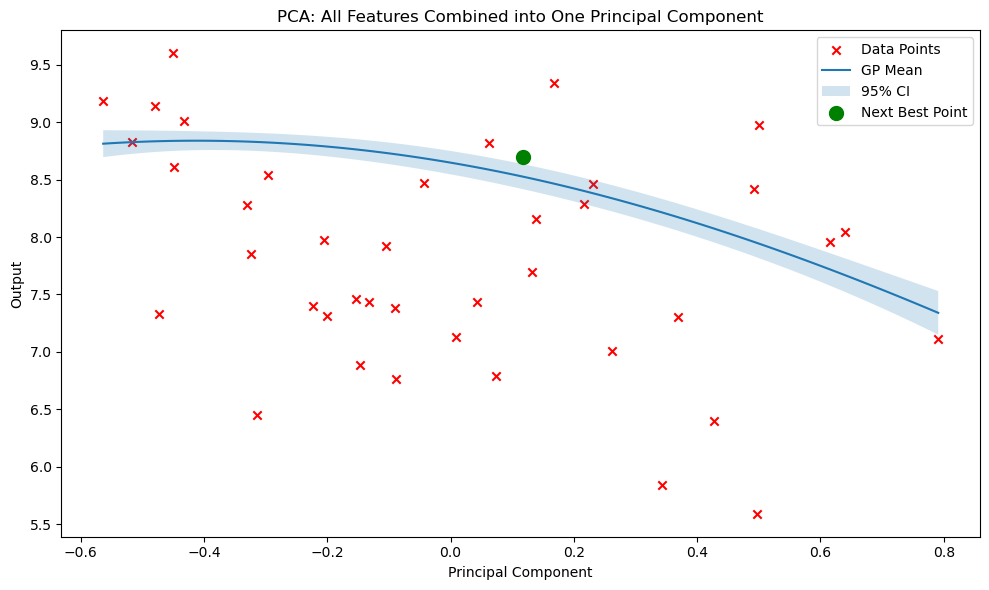

In [51]:
from scipy.optimize import minimize
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel as C, RationalQuadratic, WhiteKernel
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import norm
import warnings
from sklearn.exceptions import ConvergenceWarning

# Suppress convergence warnings for cleaner output
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Weighted Probability of Improvement (WPI)
def weighted_probability_of_improvement(X, gp, current_best, w=1.0):
    mu, sigma = gp.predict(X, return_std=True)
    sigma = np.maximum(sigma, 1e-9)
    Z = (mu - current_best) / sigma
    return w * norm.cdf(Z)

def optimize_acquisition_wpi(acquisition_func, gp, bounds, current_best, w=0.5):
    def min_obj(X):
        return -acquisition_func(X.reshape(1, -1), gp, current_best, w=w)
    x0 = np.random.uniform(bounds[0][0], bounds[0][1], size=(len(bounds),))
    res = minimize(fun=min_obj, x0=x0, bounds=bounds, method="L-BFGS-B")
    return res.x

# GP model fitting
def fit_gp_model(f1_inp, f1_out):
# Define the kernel with the initial parameters and added noise
    kernel = (
        C(initial_amplitude, (1e-2, 1e2)) *  # Scaling factor
        RBF(length_scale=initial_length_scale, length_scale_bounds=(1e-2, 2)) +  # RBF kernel
        WhiteKernel(noise_level=1e-4, noise_level_bounds=(1e-10, 0.1))  # Noise kernel
    )


    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=42)
    gp.fit(f1_inp, f1_out)
    return gp

# Assuming f1_inp and f1_out are defined and loaded appropriately
f1_out = f1_out.ravel()
gp = fit_gp_model(f1_inp, f1_out)

bounds = [(0, 1) for _ in range(f1_inp.shape[1])]
current_best = np.max(f1_out)
w = 1
next_point = optimize_acquisition_wpi(weighted_probability_of_improvement, gp, bounds, current_best, w=w)
next_z = gp.predict(next_point.reshape(1, -1))[0]


# ---------------------- Visualisation---------------------------



# Quick PCA Visualization
pca = PCA(n_components=1)
t_data = pca.fit_transform(f1_inp).ravel()
t_next = pca.transform(next_point.reshape(1, -1)).item()
t_values = np.linspace(t_data.min(), t_data.max(), 100)
X_plot = pca.inverse_transform(t_values.reshape(-1, 1))

mean_pred, std_pred = gp.predict(X_plot, return_std=True)
plt.figure(figsize=(10, 6))
plt.scatter(t_data, f1_out, color='red', marker='x', label='Data Points')
plt.plot(t_values, mean_pred, label='GP Mean')
plt.fill_between(t_values, mean_pred - 1.96 * std_pred,
                 mean_pred + 1.96 * std_pred, alpha=0.2, label='95% CI')
plt.scatter(t_next, next_z, color='green', s=100, marker='o', label='Next Best Point')
plt.title('PCA: All Features Combined into One Principal Component')
plt.xlabel('Principal Component')
plt.ylabel('Output')
plt.legend()
plt.tight_layout()
plt.show()


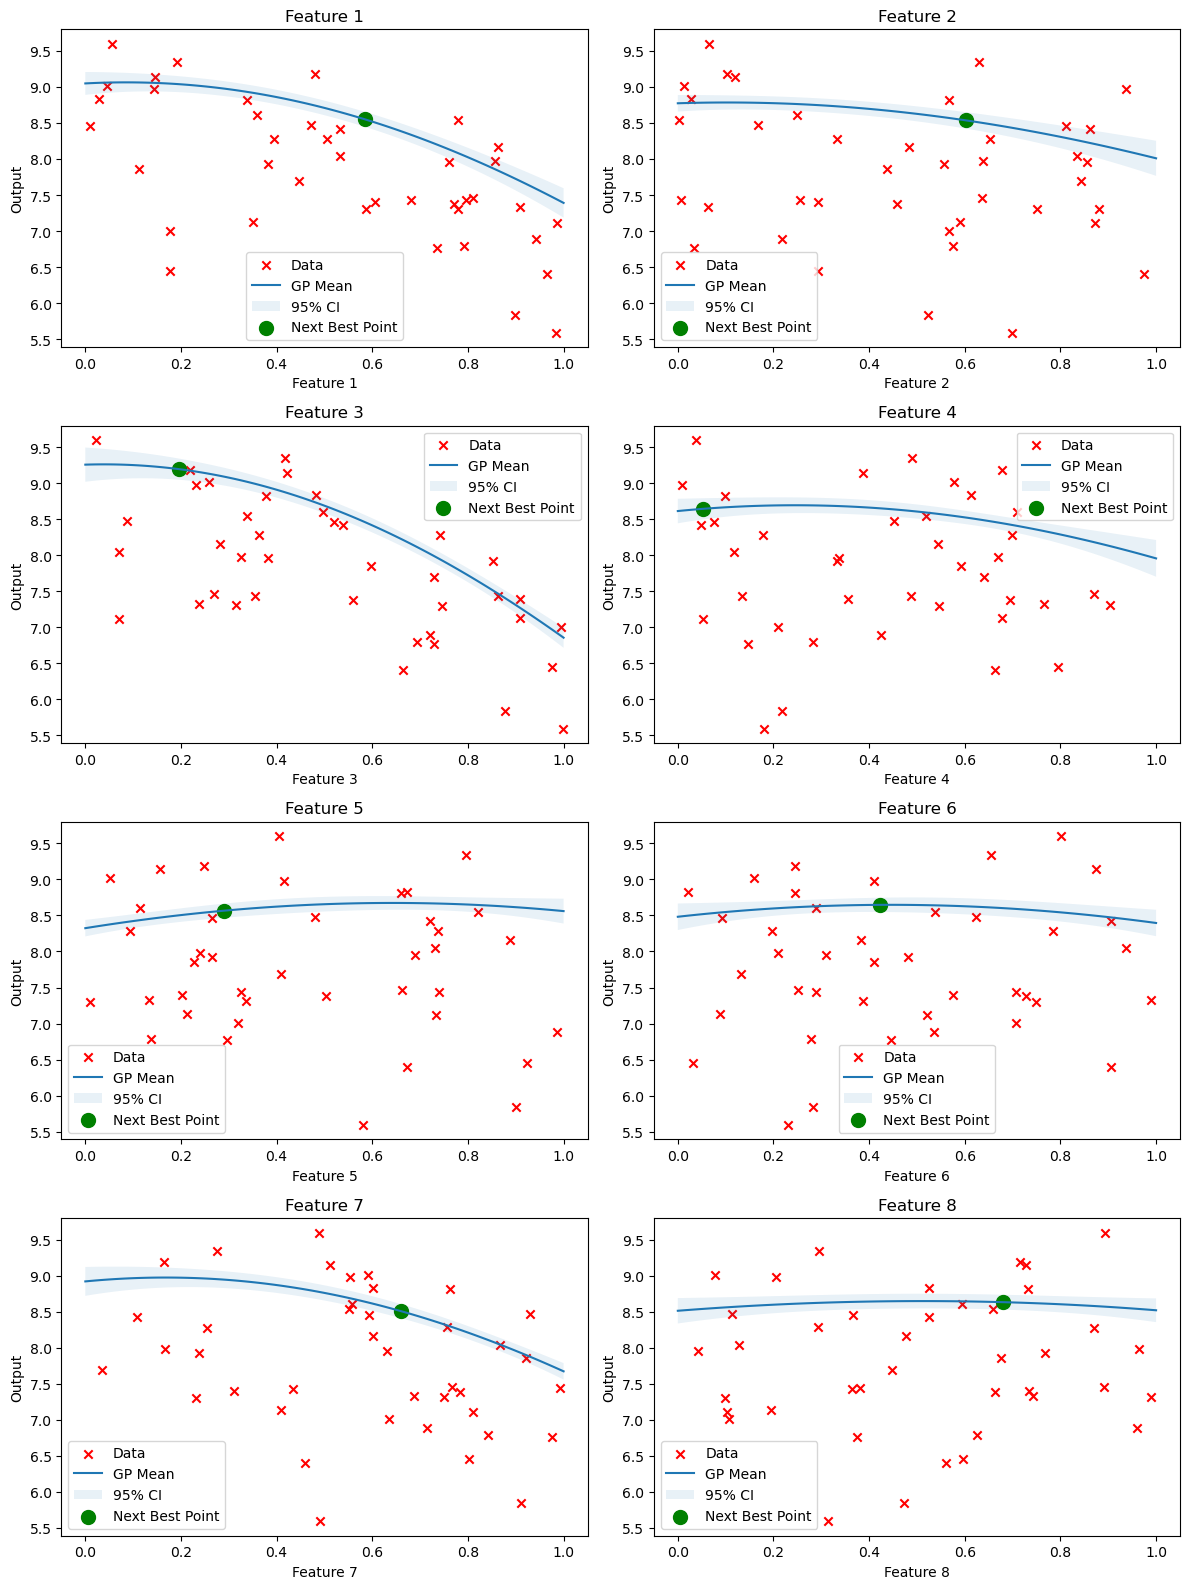

Next best point (46): [0.58549396 0.60235574 0.19555371 0.05332712 0.28945606 0.42215234
 0.66062271 0.67986459]
Predicted mean at next best point: 8.6929
Predicted std at next best point: 0.1166


In [59]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate feature means and set up grid
means_other_features = np.mean(f1_inp, axis=0)
grid = np.linspace(0, 1, 100)

# Predict at the next best point
next_mean, next_std = gp.predict(next_point.reshape(1, -1), return_std=True)

# Plot for each feature
fig, axes = plt.subplots(4, 2, figsize=(12, 16))
for i, ax in enumerate(axes.ravel()):
    # Prepare grid points for this feature
    X_plot = np.tile(means_other_features, (100, 1))
    X_plot[:, i] = grid
    mean_pred, std_pred = gp.predict(X_plot, return_std=True)

    # Plot data, GP mean, and confidence interval
    ax.scatter(f1_inp[:, i], f1_out, color='r', marker='x', label='Data')
    ax.plot(grid, mean_pred, label='GP Mean')
    ax.fill_between(grid, mean_pred - 1.96 * std_pred, mean_pred + 1.96* std_pred, alpha=0.1, label='95% CI')
    
    # Highlight next best point
    X_next = means_other_features.copy()
    X_next[i] = next_point[i]
    y_next_dim = gp.predict(X_next.reshape(1, -1))[0]
    ax.scatter(next_point[i], y_next_dim, color='green', s=100, marker='o', label='Next Best Point')

    ax.set_title(f'Feature {i+1}')
    ax.set_xlabel(f'Feature {i+1}')
    ax.set_ylabel('Output')
    ax.legend()

plt.tight_layout()
plt.show()

print("Next best point (46):", next_point)
print(f"Predicted mean at next best point: {next_mean[0]:.4f}")
print(f"Predicted std at next best point: {next_std[0]:.4f}")


IndexError: index 6 is out of bounds for axis 0 with size 6

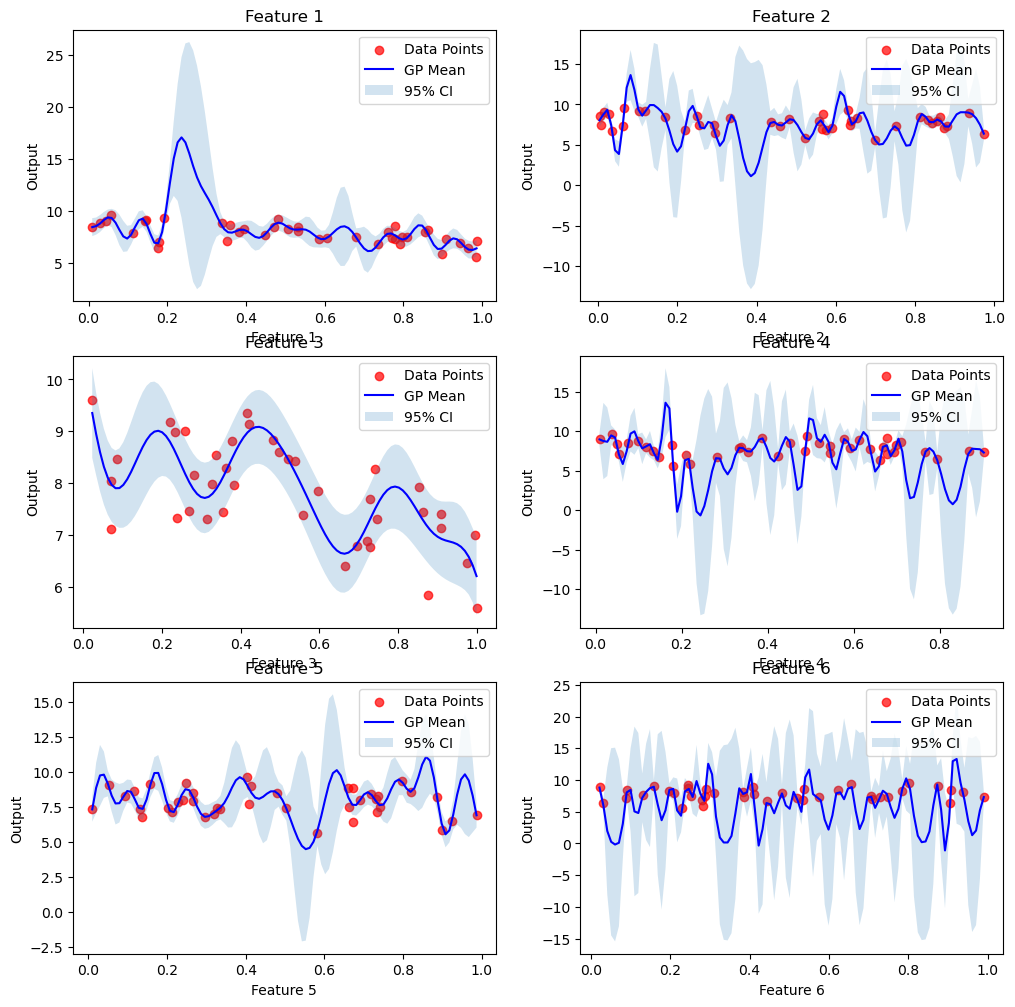

In [60]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.preprocessing import MinMaxScaler

# Define kernel with given parameters
kernel = (
    C(0.5**2, (1e-3, 1e3)) *  # Scaling factor
    RBF(length_scale=0.3, length_scale_bounds=(1e-2, 1.0)) +  # RBF kernel
    WhiteKernel(noise_level=1e-4, noise_level_bounds=(1e-12, 0.1))  # Noise kernel
)

# Initialize Gaussian Process Regressor
def fit_gp(X, y):
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=5, random_state=42)
    gp.fit(X.reshape(-1, 1), y)
    return gp

# Visualize GP fit for each feature
fig, axes = plt.subplots(3, 2, figsize=(12, 12))  # Adjust rows/columns for features
axes = axes.ravel()  # Flatten axes for easy iteration

for i in range(f1_inp.shape[1]):  # Loop over each feature
    X_feature = f1_inp[:, i]  # Select single feature as input
    gp = fit_gp(X_feature, f1_out)  # Fit GP model
    
    # Generate prediction grid
    X_grid = np.linspace(X_feature.min(), X_feature.max(), 100).reshape(-1, 1)
    mean_pred, std_pred = gp.predict(X_grid, return_std=True)
    
    # Plot the data and GP predictions
    ax = axes[i]
    ax.scatter(X_feature, f1_out, color='red', label='Data Points', alpha=0.7)
    ax.plot(X_grid, mean_pred, color='blue', label='GP Mean')
    ax.fill_between(
        X_grid.ravel(), 
        mean_pred - 1.96 * std_pred, 
        mean_pred + 1.96 * std_pred, 
        alpha=0.2, label='95% CI'
    )
    ax.set_title(f'Feature {i + 1}')
    ax.set_xlabel(f'Feature {i + 1}')
    ax.set_ylabel('Output')
    ax.legend()

# Hide unused subplots if feature count < axes
for j in range(f1_inp.shape[1], len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()
